# Predicting Play Duration Based On Age and Experience Level
## Introduction

A UBC research group has set up a Minecraft server with the intention of collecting data about how people play video games. They collect data by recording user gameplay as they navigate throughout the minecraft server. In order to maximize their data collection, they need to know which type of players to recruit, as well as when and how to recruit them. Thus, our project aims to find how different characteristics of players impact how long people play Minecraft for and how often. 

Data provided to us includes two data sets: players.csv and sessions.csv. Sessions.csv provides specific time stamps of when players logged onto minecraft server and when they logged off as well as providing an anonymous email that correlates to players specific in the players dataset. Nevertheless, only players.csv was used to answer the question since it provided sufficient information. 

Players.csv contains a list of player characteristics such as name, gender, age, experience, how long they have played minecraft for on the UBC server, and more. The dataset provides a great amount of detail for each player. The experience column includes 5 categories: Amateur, Beginner, Pro, Regular, and Veteran. Meanwhile, the gender column has a wide variety of genders including male, female, non-binary, agender, two-spirited, and other/prefer-not-to-say. Although these columns were provided to us as character data types (chr), for our analysis we will consider them to be factor data types (fct).


The tables below contains information about the columns in each data set.

Players data:

| Variable Name | Type | Meaning |
|---------------|------|---------|
| experience    | chr  | amount of experience a player has in Minecraft |
| subscribe     | lgl | whether the player is subscribed to emails |
| hashedEmail   | chr | players email in hashed (coded) form, unique identifier |
| played_hours    | dbl | number of hours played on the server |
| name          | chr | player's pseudonym on PLAIcraft |
| gender        | chr | player's chosen gender |
| age | dbl | player's chosen age in years |
| individualId | lgl | not accessible: if individual has an id  |
| organizationName | lgl | not accessible: if signup is from an organization |

Sessions data:

| Variable Name | Type | Meaning |
|---------------|------|---------|
| hashedEmail | chr | players email in hashed (coded) form, unique identifier |
| start_time | chr | date and time when the player logged onto the server |
| end_time | chr | date and time when the player logged off the server |
| original_start_time | dbl | a time in UNIX timestamp format, logging the scheduled <br> start time as number of seconds since January 1 1970 at UTC |
| original_end_time | dbl | a time in UNIX timestamp format, logging the scheduled <br> end time as number of seconds since January 1 1970 at UTC |

The question we are trying to answer is: "Can we predict the amount of time a player will play given their age and gender?" To answer the question, we will be using K-nn regression to predict the amount of time a user will play given their age and experience level. As mentioned above, we will only be using the players data set as it contains all the information we need to conduct our analysis. The response variable is `played_hours` and the predictor variables are `age` and `experience`. This will allow us to predict what demographic a person with a large play time would have, hence who would be able to contribute the most data from playing the longest.

It is important to note that there are some issues with the players data set. The data collection method involved collecting player input through a survey, however self-reported data may not always be accurate. For example, many people lie about their age online and there is no way to verify that a player’s chosen age is their real age. Innacurate data may affect the results of the data analysis and should be taken into consideration.

## Methods and Results

For this project, we will begin by using wrangling techniques to clean the data, then creating exploratory visualizations, and finally creating a KNN regression model to make predictions.

First, we will load the libraries needed to perform our analysis.

In [2]:
# load libraries
library(tidyverse)
library(tidymodels)
library(tibble)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then, we will load the data using read_csv.

In [3]:
# read data
players_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
head(players_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


To perform K-nn regression, all variables must be numerical. This means we need to convert `experience` from characters into numbers. We also need to filter our data set so that it only includes the columns necessary for analysis: `age`, `experience`, `and played_hours`

In [5]:
# convert categorical experience data into numerical data
players  <- players_data |> 
    mutate(experience = case_when(
        experience == "Amateur" ~ 1,
        experience == "Beginner" ~ 2,
        experience == "Pro" ~ 3,
        experience == "Regular" ~ 4,
        experience == "Veteran" ~ 5,)) |>
    select(experience, played_hours, age)  # select only the columns needed for analysis
head(players)

experience,played_hours,age
<dbl>,<dbl>,<dbl>
3,30.3,9
5,3.8,17
5,0.0,17
1,0.7,21
4,0.1,21
1,0.0,17


Since we are performing K-nn regression, we need to split our data into training and testing sets, where we will first create the model using training data, then test its accuracy with testing data. It is important to set the seed before splitting the data as it ensures the data is split in the same way every time, making it reproducible. 

In [6]:
set.seed(1)

# split data into training and testing
players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

Now that we have split the data, we can explore the data set through visualizations. First we will create a bar chart displaying the count of each `experience` value in the data set. To do this, we need to convert `experience` into a factor type.

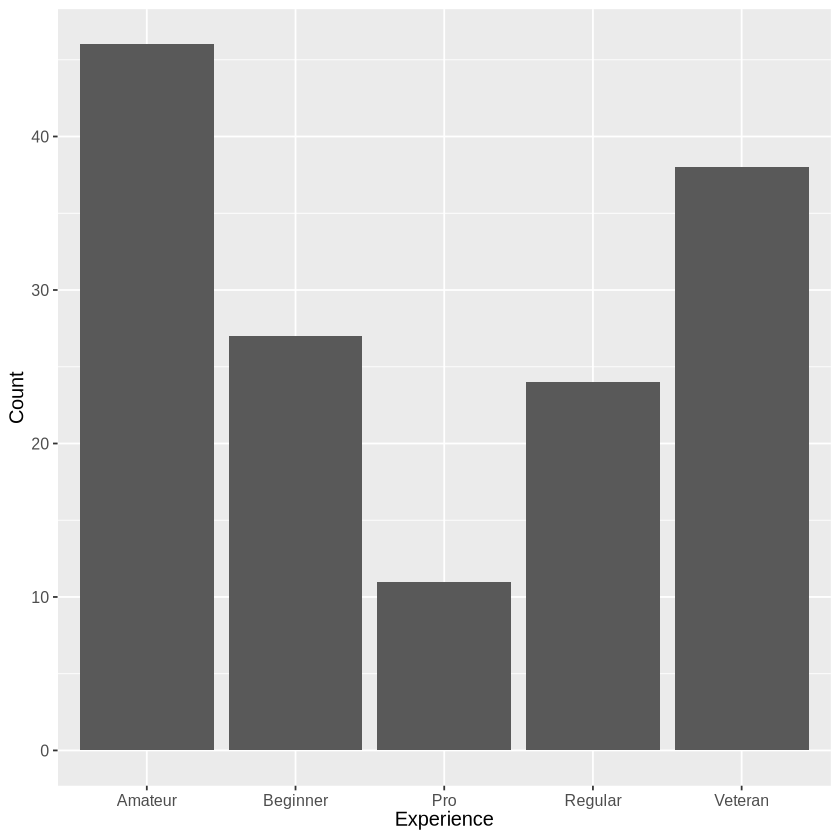

In [7]:
# convert the experience column into a factor to plot as a bar graph
players_mutate <- players_train |>
    mutate(fct_experience = factor(experience, 
                                   levels = 1:5,
                                   labels = c("Amateur", "Beginner", "Pro", "Regular", "Veteran")))
# plot experience counts
players_ex <- players_mutate |>
  ggplot(aes(x = fct_experience)) +
      geom_bar() +
      labs(x = "Experience",
           y = "Count") +
      theme(text = element_text(size = 12))

players_ex

This shows that the 'amateur' experience level has the most counts of players and 'pro' has the least.

We can also plot `experience` against `played_hours`.

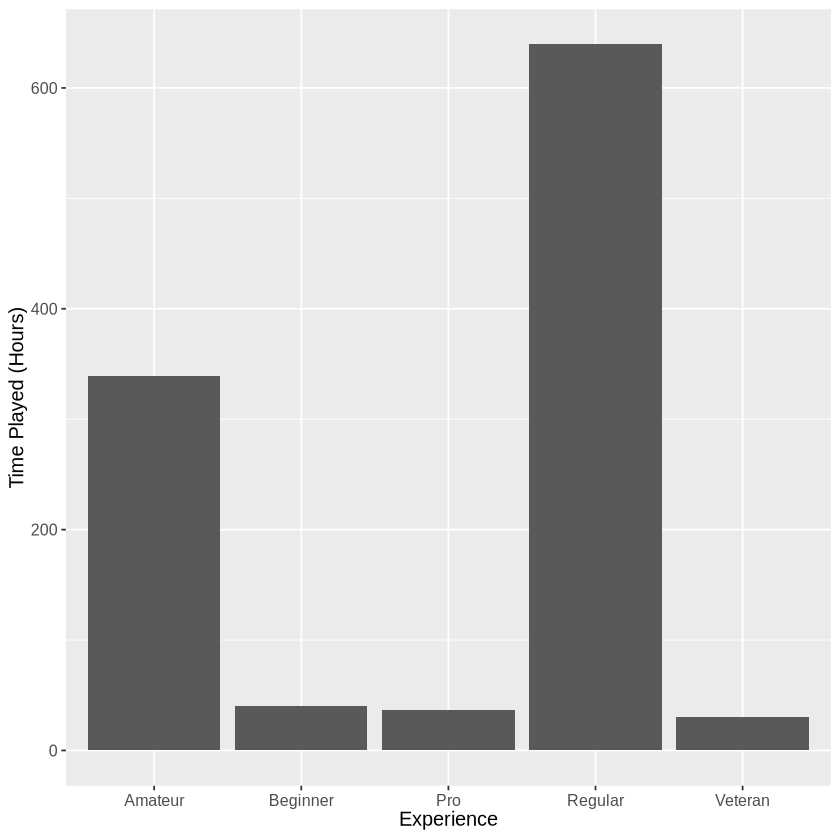

In [31]:
ex_vs_hrs <- players_mutate |>
  ggplot(aes(x = fct_experience, y = played_hours)) +
      geom_bar(stat = "identity") +
      labs(x = "Experience",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))

ex_vs_hrs

This shows that `regular` and `amateur` players have contributed the most time in the current data set.

We can also view the distribution of ages in the data set.

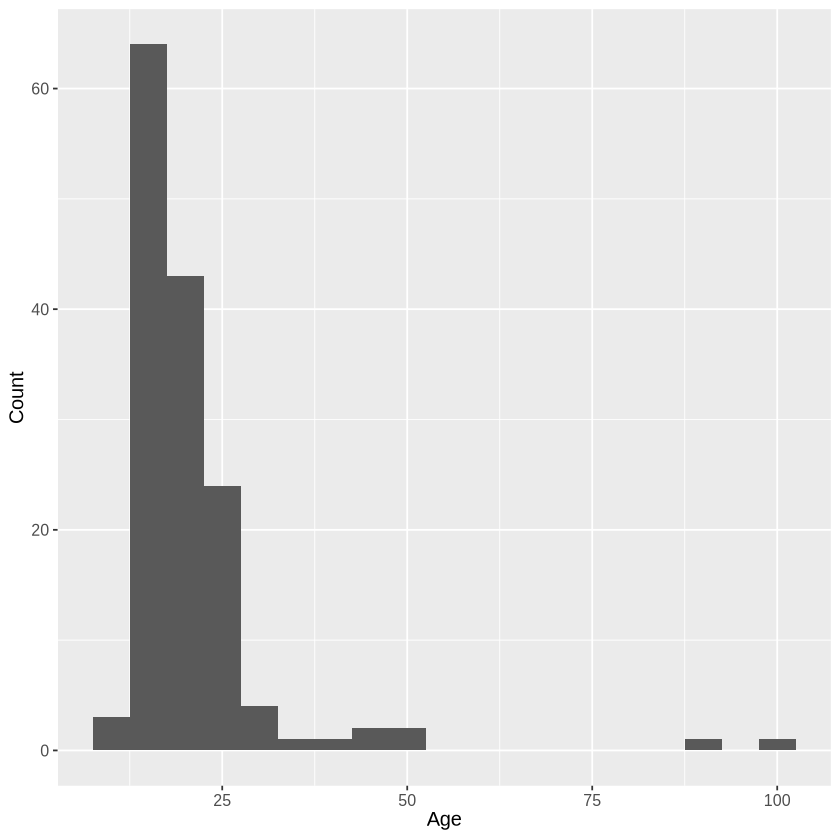

In [32]:
age_dist <- players_train |>
    ggplot(aes(x = age)) +
        geom_histogram(binwidth = 5) +
        labs(x="Age", y="Count") +
        theme(text = element_text(size = 12))
age_dist

This shows that most of the data comes from players under the age of 25.

Finally, we can plot `age` against `played_hours`.

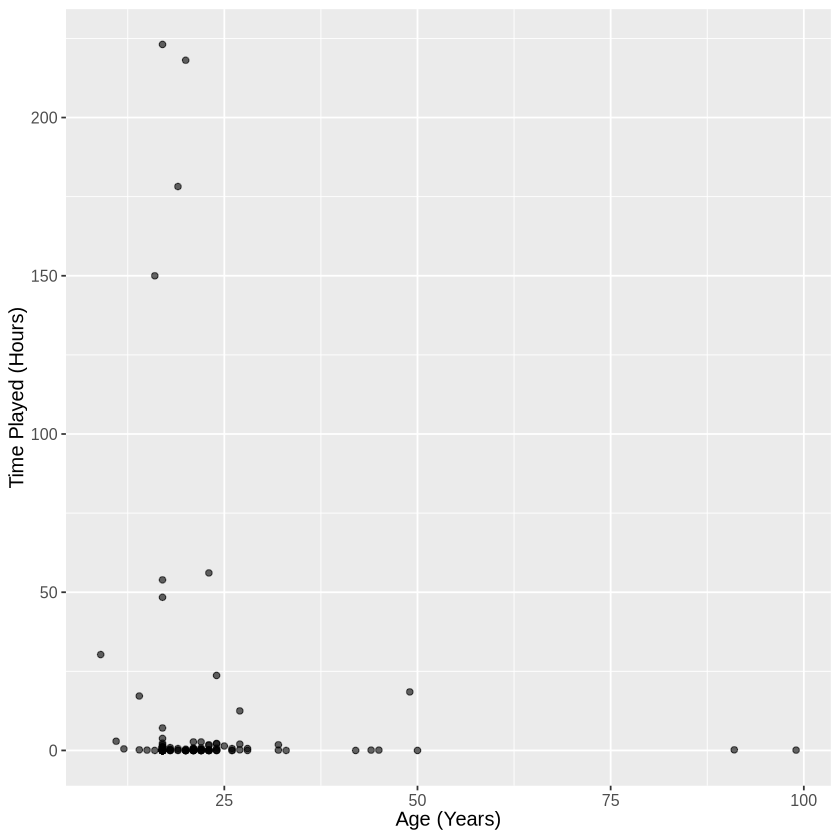

In [33]:
age_vs_hrs <- players_train |>
  ggplot(aes(x = age, y = played_hours)) +
      geom_point(alpha = 0.6) +
      labs(x = "Age (Years)",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))
age_vs_hrs

Now that we have an understanding of the data set, we can begin building our K-nn regression model. To pick the optimal K value, we will use cross validation to test a sequence of k values and choose the one that produces the lowest rmse.

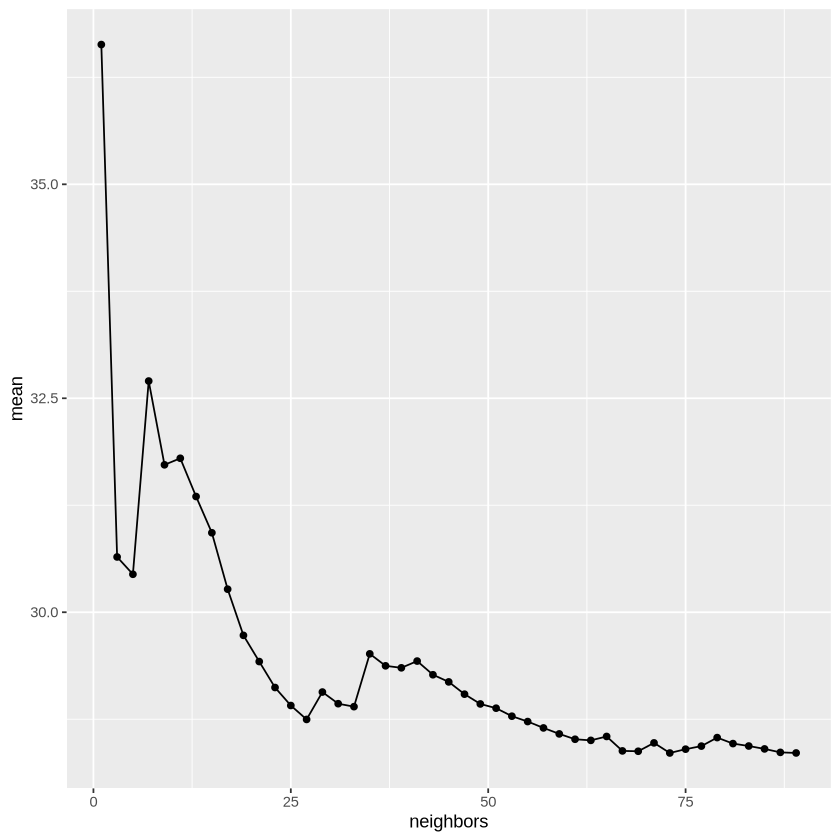

In [34]:
set.seed(1)

# 1. create the recipe
players_recipe <- recipe(played_hours ~ age + experience, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2. create the model specification with neighbors set to tune()
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# 3. create a 5-fold cross validation object
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

# 4. create a workflow
players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

# 5. create grid of possible k values
gridvals <- tibble(neighbors = seq(from = 1, to = 90, by = 2))

# 6. tune the model with the possible k values and collect metrics
players_results <- players_wkflw |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

# 7. visualize metrics
plot_results <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line()
plot_results

In [45]:
# 8. find optimal k value
min_kval <- players_results |>
    filter(mean == min(mean))
min_kval

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
73,rmse,standard,28.35536,5,8.384103,Preprocessor1_Model37


Now we can use k = 73 to create our final model and make predictions.

In [47]:
kmin <- min_kval |> pull(neighbors)

# recreate model with kmin
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

# fit the model with the training data
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

# predict on the testing data
players_predictions <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    select(.pred, played_hours)

head(players_predictions)
tail(players_predictions)

.pred,played_hours
<dbl>,<dbl>
5.230137,0.0
9.416438,0.0
5.210959,0.0
10.250685,0.0
2.245205,1.5
5.210959,0.0


.pred,played_hours
<dbl>,<dbl>
9.416438,0.0
9.416438,0.1
5.210959,0.8
5.210959,32.0
5.209589,0.0
5.230137,0.0


## Discussion